In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib
import time
import math
from training import util

In [30]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3, normalize=False, offset=50)
#trainset = toy.TrigonometricToyDataset(sample_count=200, normalize=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

device = torch.device("cpu")

Epoch 0: loss 106.10914611816406
Epoch 100: loss 2.7678916454315186
Final loss 2.5966603755950928


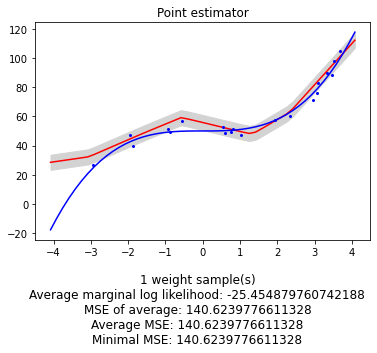

In [31]:
# Point estimator with L2 regularization
importlib.reload(util)

torch.manual_seed(42)

pp_model = util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 100), 
    nn.ReLU(),
    nn.Linear(100, 1)
), torch.tensor(3))

optimizer = torch.optim.SGD(pp_model.parameters(), lr=0.01)
for epoch in range(160):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        mean, var = pp_model(data)
        loss = F.gaussian_nll_loss(mean, target, var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_pp(input):
    return [pp_model(input)]

trainset.plot("Point estimator", eval_pp, plot_sigma=True)

Epoch 0: loss 106.11402893066406
Epoch 100: loss 2.773423433303833
Final loss 2.5967297554016113


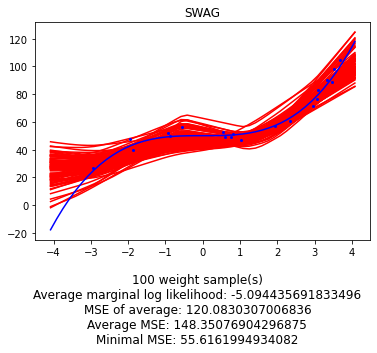

In [19]:
# SWAG trained with SGD and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
importlib.reload(swag)

torch.manual_seed(42)

swag_model = util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 100), 
    nn.ReLU(), 
    nn.Linear(100, 1)
), torch.tensor(3))
optimizer = torch.optim.SGD(swag_model.parameters(), lr=0.01, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(swag_model, 5, 10)

for epoch in range(160):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        mean, var = swag_model(data)
        loss = F.gaussian_nll_loss(mean, target, var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    wrapper.update(epoch)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_swag(input):
    return [wrapper.sample(swag_model, input) for _ in range(100)]

trainset.plot("SWAG", eval_swag)

Training model 0
  Epoch 0: loss 103.316650390625
  Epoch 100: loss 2.7680838108062744
  Final loss 6.1263322830200195
Training model 1
  Epoch 0: loss 98.11000061035156
  Epoch 100: loss 3.8558602333068848
  Final loss 3.401792049407959
Training model 2
  Epoch 0: loss 96.33790588378906
  Epoch 100: loss 2.561720609664917
  Final loss 2.1329236030578613
Training model 3
  Epoch 0: loss 110.7802734375
  Epoch 100: loss 3.9887962341308594
  Final loss 2.4877331256866455
Training model 4
  Epoch 0: loss 112.5393295288086
  Epoch 100: loss 3.227146863937378
  Final loss 2.7807466983795166


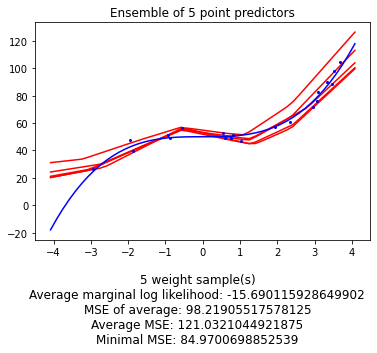

In [21]:
# Ensemble of point estimators with L2 regularization

from training import ensemble
importlib.reload(ensemble)

torch.manual_seed(42)

ensemble_count = 5
ensemble_model = [util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 100), 
    nn.ReLU(), 
    nn.Linear(100, 1)
), torch.tensor(3)) for _ in range(ensemble_count)]

for i, model in enumerate(ensemble_model):
    print(f"Training model {i}")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
    for epoch in range(160):
        epoch_loss = torch.tensor(0, dtype=torch.float)
        for data, target in trainloader:
            optimizer.zero_grad()
            mean, var = model(data)
            loss = F.gaussian_nll_loss(mean, target, var)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
        if epoch % 100 == 0:
            print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
    print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_esemble(input):
     return [model(input) for model in ensemble_model]
trainset.plot(f"Ensemble of {ensemble_count} point predictors", eval_esemble)

Epoch 0: loss 79.41371154785156
Epoch 100: loss 17.3721923828125
Final loss 10.63794231414795


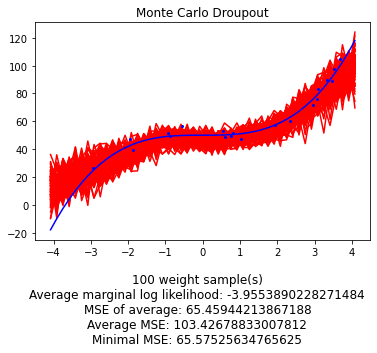

In [22]:
# MC dropout

torch.manual_seed(42)

p = 0.3

dropuout_model = util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 150), 
    nn.ReLU(), 
    nn.Dropout(p),
    nn.Linear(150, 1),
), torch.tensor(3))

optimizer = torch.optim.SGD(dropuout_model.parameters(), lr=0.01)
for epoch in range(160):
    dropuout_model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        mean, var = dropuout_model(data)
        loss = F.gaussian_nll_loss(mean, target, var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_dropout(input):
    dropuout_model.train() # Enable dropout
    return [dropuout_model(input) for _ in range(100)]

trainset.plot("Monte Carlo Droupout", eval_dropout)

Epoch 0: loss 278.62176513671875
Epoch 100: loss 39.01836395263672
Final loss 40.86430740356445


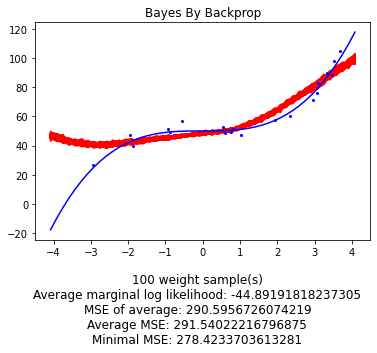

In [23]:
# Bayesian NN (Bayes-by-Backprop)

from training import bbb, util
importlib.reload(bbb)
importlib.reload(util)

torch.manual_seed(42)

pi = 0.5  # 0.25, 0.5, 0.75
sigma1 = np.exp(-1)  # 0, 1, 2
sigma2 = np.exp(-7)  # 6, 7, 8
#prior = util.GaussianMixture(pi, sigma1, sigma2)
prior = torch.distributions.Normal(0, 1.0)

model = util.GaussWrapper(nn.Sequential(
    bbb.BBBLinear(1, 100, prior, prior, device, mc_sample=2, sampling="activations"),
    nn.ReLU(),
    bbb.BBBLinear(100, 1, prior, prior, device, mc_sample=2, sampling="activations")
), torch.tensor(3))
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
def uncurried_nll_loss(output, target):
    mean, var = output
    return F.gaussian_nll_loss(mean, target, var)

for epoch in range(160):
    loss = bbb.run_bbb_epoch(model, optimizer, uncurried_nll_loss, trainloader, device)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {loss / (len(trainloader) * batch_size)}")
print(f"Final loss {loss / (len(trainloader) * batch_size)}")


def eval_bbb(input):
    model.eval()
    return [model(input) for _ in range(100)]
trainset.plot("Bayes By Backprop", eval_bbb)

Epoch 0: loss 351.7580261230469
Epoch 100: loss 5.581376075744629
Final loss 4.597132682800293


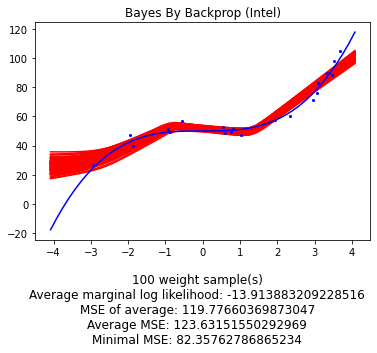

In [32]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

torch.manual_seed(42)

model = util.GaussWrapper(nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
), torch.tensor(3))
dnn_to_bnn(model, {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",
        "moped_enable": False,
        "moped_delta": 0.5,
})

optimizer = torch.optim.Adam(model.parameters(), 0.01)
for epoch in range(160):
    model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        mean, var = model(data)
        loss = get_kl_loss(model) / batch_size + F.gaussian_nll_loss(mean, target, var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_bayes(input):
    model.eval()
    return [model(input) for _ in range(100)]
trainset.plot("Bayes By Backprop (Intel)", eval_bayes)